<a href="https://colab.research.google.com/github/flora0110/podcast_segment_headine/blob/main/podcast_to_headline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [3]:
!pip install word2vec

     |████████████████████████████████| 42 kB 586 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=3af45a0303e7a6fc2044b597faf915556da09a502dfc62d4888e845a70c929ca
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [4]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [5]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

--2022-04-06 12:43:08--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  2.15MB/s    in 14s     

2022-04-06 12:43:22 (2.14 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  ./text8.zip
  inflating: text8                   


In [6]:
links = {'podcast_text': 'https://raw.githubusercontent.com/grace-boop/podcast/main/5_Ways'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

--2022-04-06 12:43:24--  https://raw.githubusercontent.com/grace-boop/podcast/main/5_Ways
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33953 (33K) [text/plain]
Saving to: ‘5_Ways’

5_Ways              100%[===================>]  33.16K  --.-KB/s    in 0.002s  

2022-04-06 12:43:24 (13.2 MB/s) - ‘5_Ways’ saved [33953/33953]



## Train wordvectors

In [7]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [8]:
model.save(wrdvec_path)

In [9]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [10]:
!pip install textsplit

     |████████████████████████████████| 154 kB 5.1 MB/s 


In [11]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [12]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [13]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  20#@param {type:"integer"}

penalty 43.06
473 sentences, 36 segments, avg 13.14 sentences per segment
optimal score 13014.41, greedy score 12959.32
[13014.41332855796, 12959.322630299554]
(13014.41332855796, 12959.322630299554)
ratio of scores 1.0043


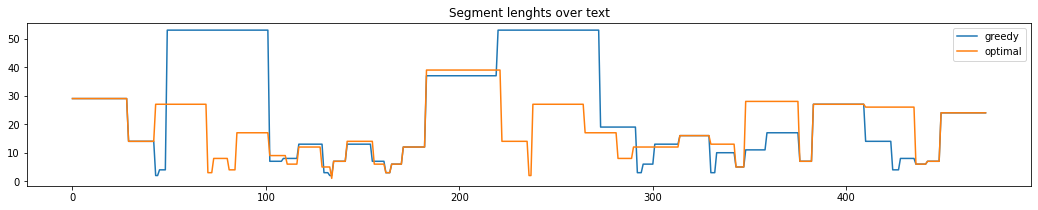

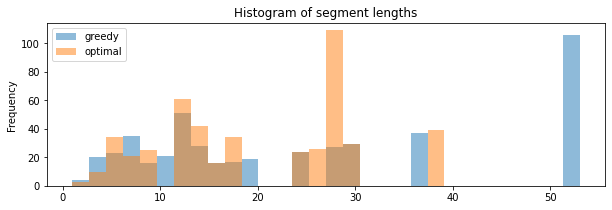

In [14]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [15]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['\nHi, welcome to the podcast and welcome to another episode of Qantas with Hannah. ', 'Sorry for the interruption. ', "I just wanted to let you know that I'm doing a webinar and if you wanted to join it's about how to be a YouTuber. ", "It had to be you just with a bigger platform, but we're going to be doing some interactive games. ", "I'm going to edit the Vlog on the spot for you guys. ", "I'm going to answer your questions and it's going to be the funnest thing ever. ", 'So if you want to sign up, the link is down on my description box. ', 'I would love to see you there. ', 'Bye today. ', 'We are going to be talking about.\n', "Some actually, let's let our friend explained. ", 'Hi, Hannah. ', "I'm o Yanna. ", "I'm from the Philippines today. ", 'Can you make 12 about how you handle pressure and life? ', 'Transition college, entrance exam results are around the corner and it is truly nerve-racking. ', 'Can you share with us how you handled transition from high school to college an

In [16]:
print(segmented_text)

[['\nHi, welcome to the podcast and welcome to another episode of Qantas with Hannah. ', 'Sorry for the interruption. ', "I just wanted to let you know that I'm doing a webinar and if you wanted to join it's about how to be a YouTuber. ", "It had to be you just with a bigger platform, but we're going to be doing some interactive games. ", "I'm going to edit the Vlog on the spot for you guys. ", "I'm going to answer your questions and it's going to be the funnest thing ever. ", 'So if you want to sign up, the link is down on my description box. ', 'I would love to see you there. ', 'Bye today. ', 'We are going to be talking about.\n', "Some actually, let's let our friend explained. ", 'Hi, Hannah. ', "I'm o Yanna. ", "I'm from the Philippines today. ", 'Can you make 12 about how you handle pressure and life? ', 'Transition college, entrance exam results are around the corner and it is truly nerve-racking. ', 'Can you share with us how you handled transition from high school to college a

# Headline generator

In [17]:
! pip install transformers datasets

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 325 kB 48.1 MB/s 
     |████████████████████████████████| 596 kB 61.5 MB/s 
     |████████████████████████████████| 895 kB 40.8 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 6.5 MB 47.3 MB/s 
     |████████████████████████████████| 136 kB 48.9 MB/s 
     |████████████████████████████████| 1.1 MB 45.5 MB/s 
     |████████████████████████████████| 212 kB 18.4 MB/s 
     |████████████████████████████████| 127 kB 48.5 MB/s 
     |████████████████████████████████| 271 kB 6.4 MB/s 
     |████████████████████████████████| 144 kB 52.4 MB/s 
     |████████████████████████████████| 94 kB 1.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling 

In [18]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.0 MB/s 


### 處理輸入

In [19]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [20]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [21]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [22]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 90#@param {type:"integer"}

In [23]:
headlines = headlineGenerator(podcast_test, min_length, max_length)

Ignoring args : (5, 90)
Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [24]:
for headline in headlines:
  print(headline['generated_text'])

Qantas With Hannah - How to Survive in the Philippines and Study Ab
Podcast - How Did I Do It?
Is It Possible to Be Successful?
What God Considered Success
The One Who Is Not Worried About
Concentrate All of My Efforts on That.
The Kingdom of God
Hillsong College
The Philippines is Quite Hard to Have in Australia, but I am a Filipino.
Study Abroad Dad, I'll Jana
The Relationship With God Was The Reason Why I Was able To Push Through
I was Only Meant to Stay There For One Year
Hillsong College - Is it a Good Place to Stay?
Is It Possible to Get Out of Covid?
The Government is Acting So Fast.
The Philippines, the Philippines, the Philippines, the Philippines, the Philippines, the Philippines, the
The context of my parents with a covid crisis is horrible
Pandemic - Is It Safe?
Is It Time For You To Go Home?
Learn the Most Through Experience
The Last Class That I Taken
Learn How to Learn How to Cook and Cook in the Philippines
The Five Ways That I've Managed These Life Transitions
Transiti

In [33]:
# 處理重複
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  #print(type(headline['generated_text']))
  #print(headline['generated_text'])
  sentenced_healine = re.split('; |, |\.|\*|\n',headline['generated_text'])
  print(sentenced_healine)
  strs = " "  
  headlines_string[index]+=sentenced_healine[0]
  strs = sentenced_healine[0]
  for i in range(1,(len(sentenced_healine))):
    
    if(strs == sentenced_healine[i]):
      sentenced_healine[i]=" "
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
    if(sentenced_healine[i] != " "):
      headlines_string[index]+=","
      headlines_string[index]+=sentenced_healine[i]
  #print(headlines_string[index])
  index+=1

['Qantas With Hannah - How to Survive in the Philippines and Study Ab']
['Podcast - How Did I Do It?']
['Is It Possible to Be Successful?']
['What God Considered Success']
['The One Who Is Not Worried About']
['Concentrate All of My Efforts on That', '']
['The Kingdom of God']
['Hillsong College']
['The Philippines is Quite Hard to Have in Australia', 'but I am a Filipino', '']
['Study Abroad Dad', "I'll Jana"]
['The Relationship With God Was The Reason Why I Was able To Push Through']
['I was Only Meant to Stay There For One Year']
['Hillsong College - Is it a Good Place to Stay?']
['Is It Possible to Get Out of Covid?']
['The Government is Acting So Fast', '']
['The Philippines', 'the Philippines', 'the Philippines', 'the Philippines', 'the Philippines', 'the Philippines', 'the']
['The context of my parents with a covid crisis is horrible']
['Pandemic - Is It Safe?']
['Is It Time For You To Go Home?']
['Learn the Most Through Experience']
['The Last Class That I Taken']
['Learn How t

In [32]:
for headline_string in headlines_string:
  print(headline_string)

Qantas With Hannah - How to Survive in the Philippines and Study Ab
Podcast - How Did I Do It?
Is It Possible to Be Successful?
What God Considered Success
The One Who Is Not Worried About
Concentrate All of My Efforts on That,
The Kingdom of God
Hillsong College
The Philippines is Quite Hard to Have in Australia,but I am a Filipino,
Study Abroad Dad,I'll Jana
The Relationship With God Was The Reason Why I Was able To Push Through
I was Only Meant to Stay There For One Year
Hillsong College - Is it a Good Place to Stay?
Is It Possible to Get Out of Covid?
The Government is Acting So Fast,
The Philippines,the Philippines,the
The context of my parents with a covid crisis is horrible
Pandemic - Is It Safe?
Is It Time For You To Go Home?
Learn the Most Through Experience
The Last Class That I Taken
Learn How to Learn How to Cook and Cook in the Philippines
The Five Ways That I've Managed These Life Transitions
Transitioning - You're Going to Destroy a Lot of People
Leverage on Support,Numb